# Imports

In [ ]:
import numpy as np 
import xgboost as xgb
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from math import sqrt
import seaborn as sns
from scipy import stats
import os
import pickle
import tensorflow as tf
from xgboost import plot_tree
import time
from sklearn.metrics import mean_squared_error


from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM

Converting all the data to dataframes



In [ ]:
df=pd.read_excel("x.xlsx") #audio features 2008-2014
df_info=pd.read_excel("song_info1.xlsx")

In [ ]:
df_2015=pd.read_excel("x_2015.xlsx") #audio feature 2015
df_info_2015=pd.read_excel("song_info1_2015.xlsx")

In [ ]:
df_2016=pd.read_excel("x_2016.xlsx") #audio feature 2016
df_info_2016=pd.read_excel("song_info1_2016.xlsx")

In [ ]:
df_2017=pd.read_excel("x_2017.xlsx") #audio feature 2017
df_info_2017=pd.read_excel("song_info1_2017.xlsx")

In [ ]:
df_2018=pd.read_excel("x_2018.xlsx") #audio feature 2018
df_info_2018=pd.read_excel("song_info1_2018.xlsx")

In [ ]:
df_2019=pd.read_excel("x_2019.xlsx") #audio feature 2019
df_info_2019=pd.read_excel("song_info1_2019.xlsx")

# Data cleaning and preprocessing

* label encoding categorical values and plotting correlation matrix. 
* The attributes 'speechiness','duration_ms','energy' have low correlation with our target(popularity) so we dropped them
* joining some categorical values to the dataset


---


*   we perform this preprocessing for the data of all the years , 2008-2014,2015,2016,2017,2018,2019 and for each we print a confusion matrix. Hence there are 5 confusio matrices.





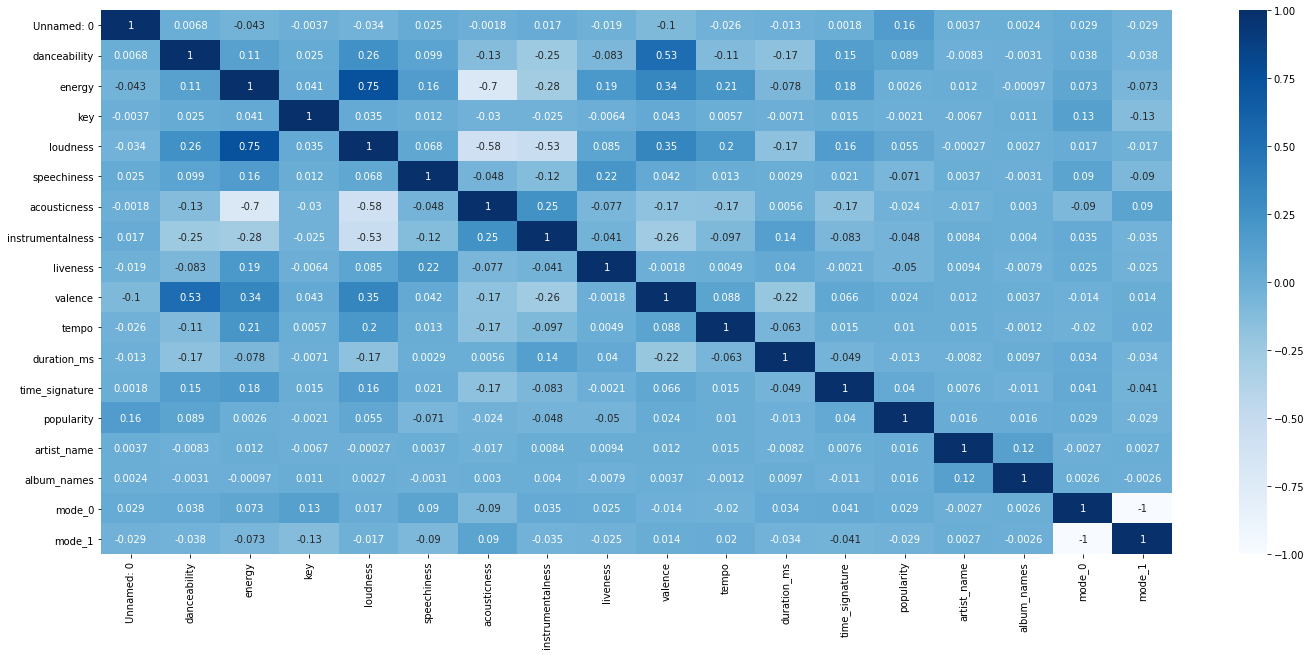

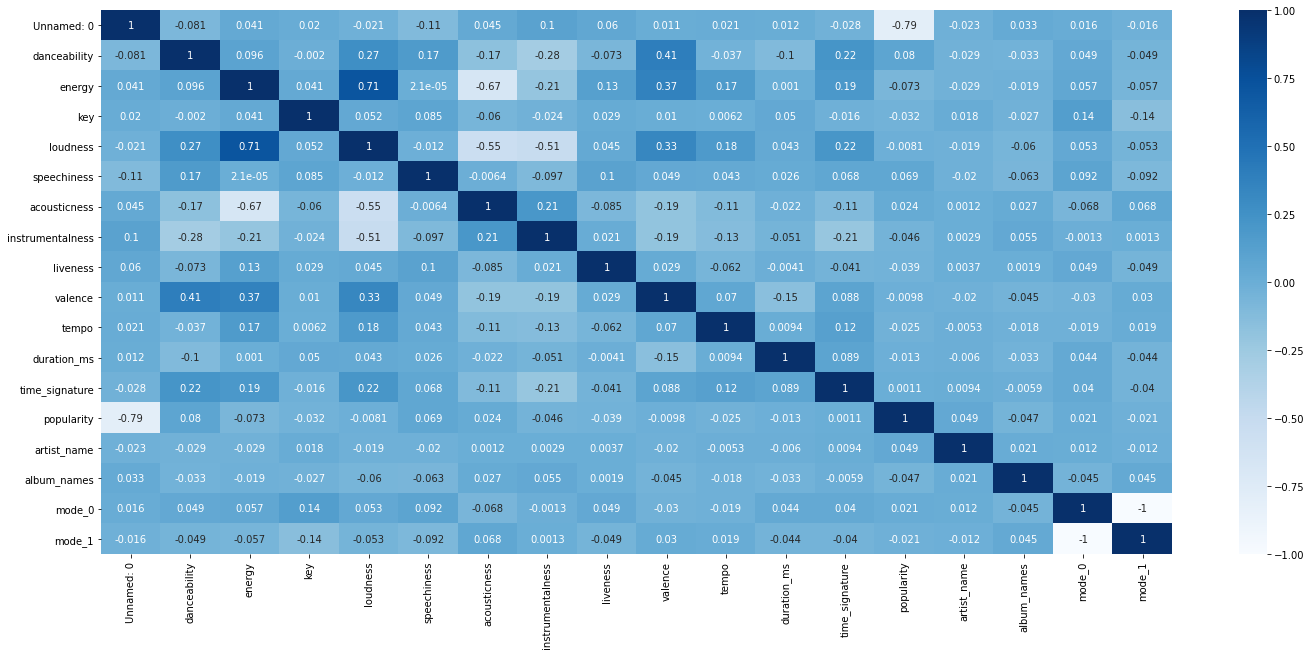

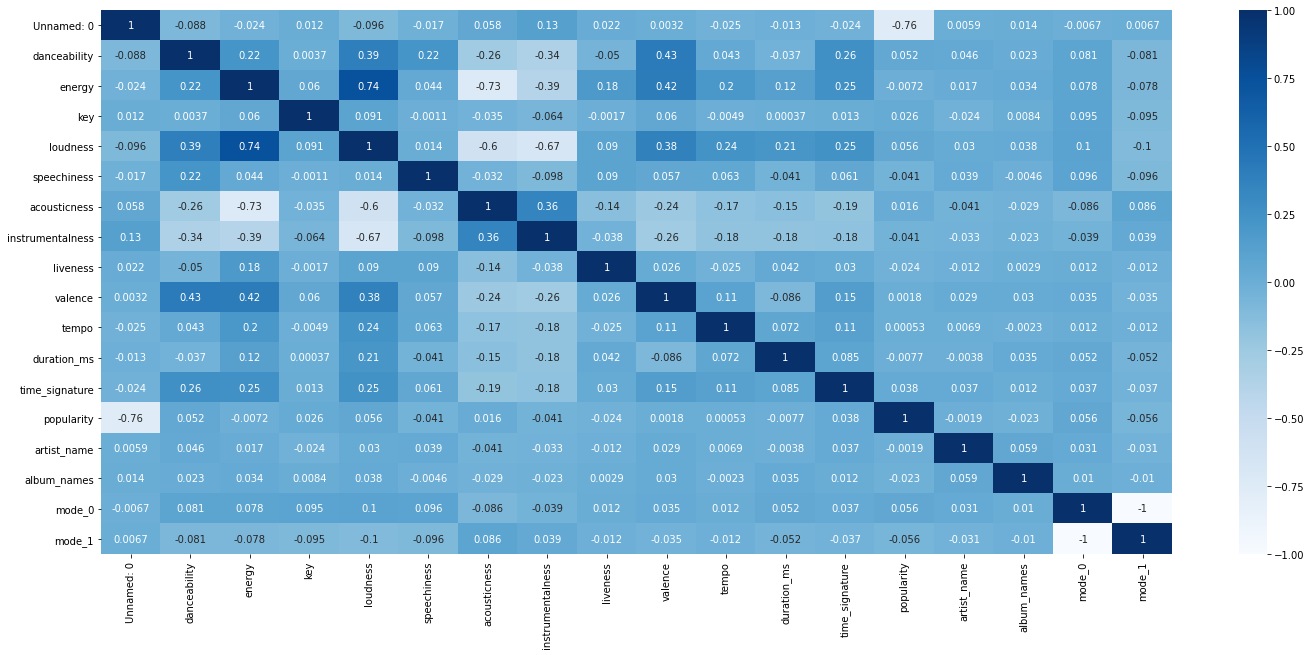

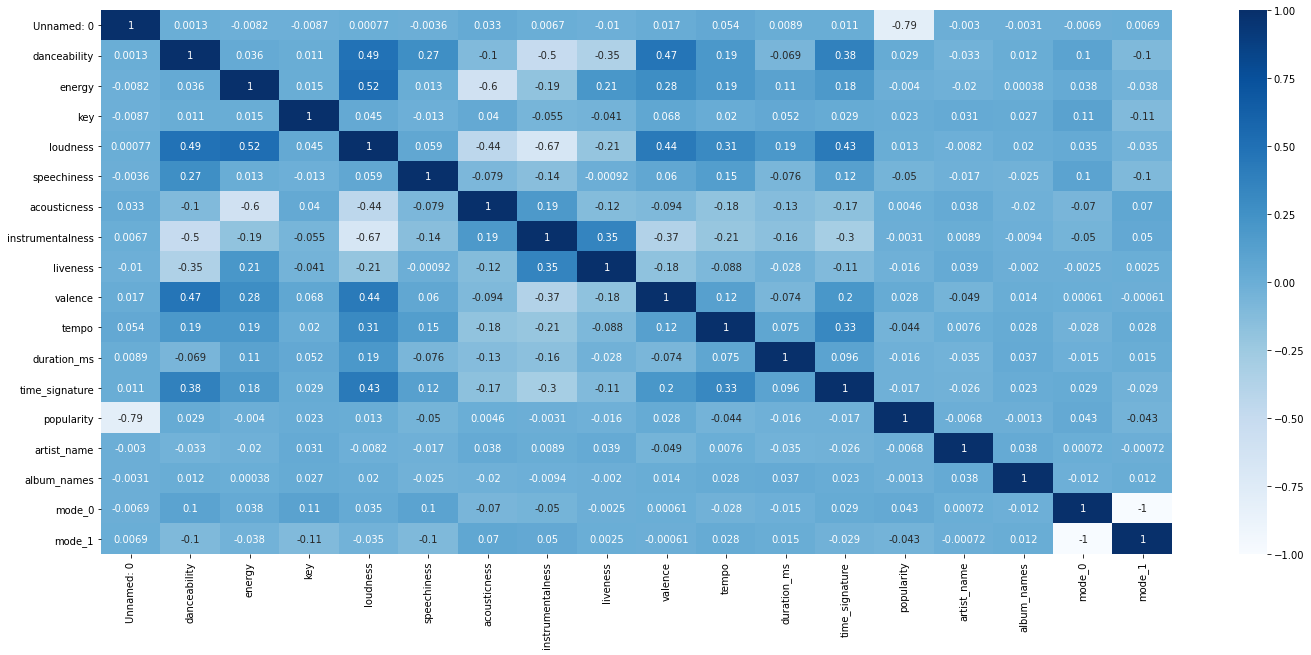

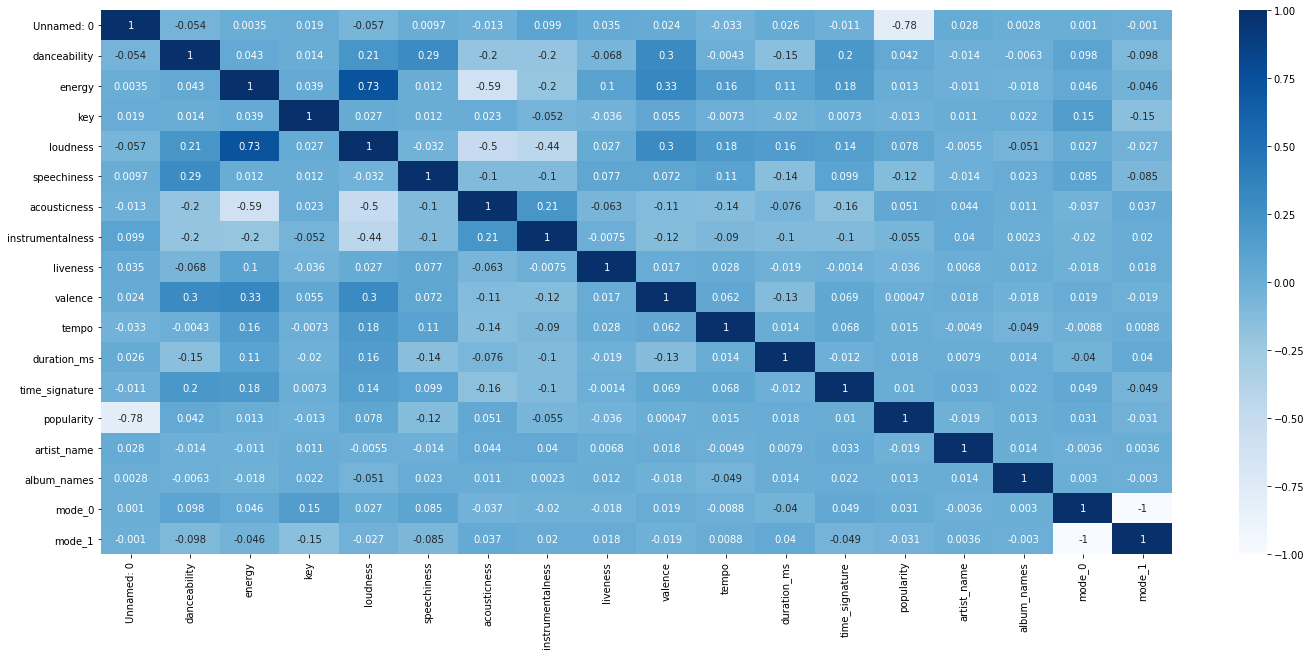

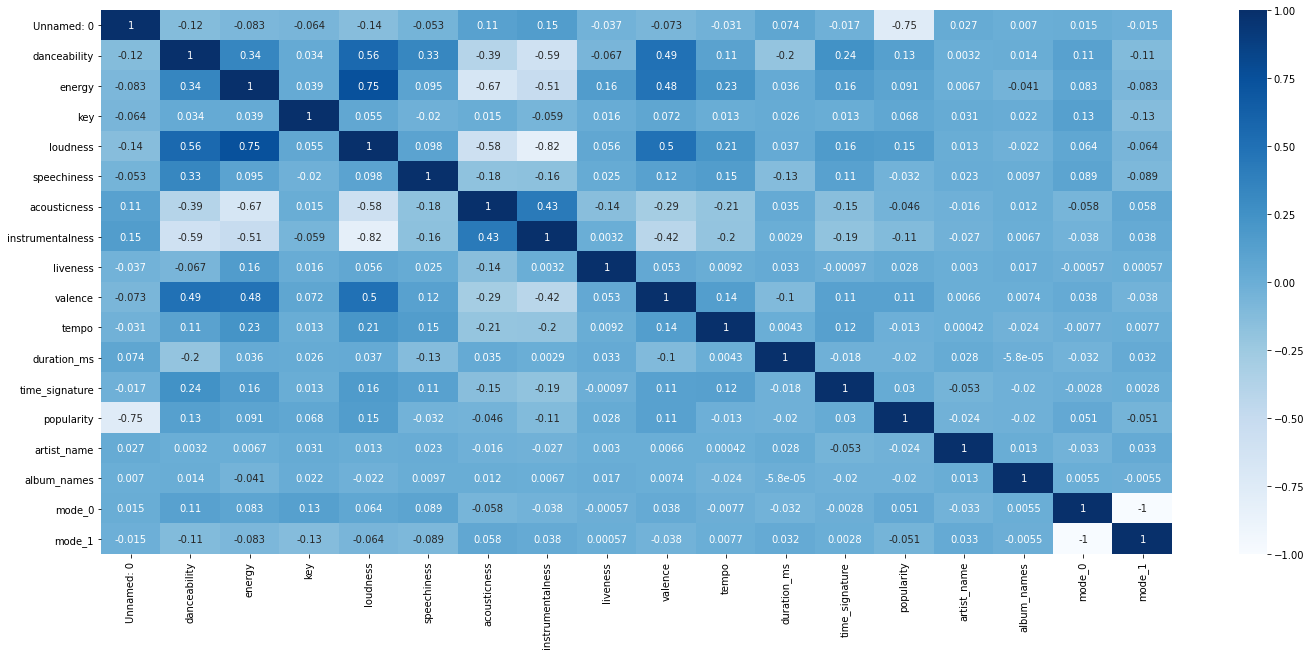

In [ ]:
def preprocess(df,df_info):
  names=df_info['artist_name']
  album = df_info['album_names']
  df = df.join(names)
  df = df.join(album)
  index_delete = df.index[df['popularity']==0]
  df = df.drop(index_delete)
  leble_en=preprocessing.LabelEncoder()
  df['artist_name']=leble_en.fit_transform(df['artist_name'])
  df['album_names']=leble_en.fit_transform(df['album_names'])
  df=pd.get_dummies(data=df,columns=['mode'])



  f,ax = plt.subplots(figsize=(24, 10))
  cor = df.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Blues, ax=ax)
  plt.show()

  df = df.drop(['speechiness','duration_ms','energy'],axis=1)

  index_delete = df.index[df['tempo']==0]  #dropped row where tempo was 0, it is a mistake maybe

  df = df.drop(index_delete)
  y=df['popularity']
  df=df.drop(['popularity'],axis=1)
  scaler = preprocessing.MinMaxScaler()
  df_scal = scaler.fit_transform(df)
  df_scal = pd.DataFrame(df_scal, columns = df.columns)
  x=df_scal.values 

  return (x,y)

(x,y)=preprocess(df,df_info)
(x_2015,y_2015)=preprocess(df_2015,df_info_2015)
(x_2016,y_2016)=preprocess(df_2016,df_info_2016)
(x_2017,y_2017)=preprocess(df_2017,df_info_2017)
(x_2018,y_2018)=preprocess(df_2018,df_info_2018)
(x_2019,y_2019)=preprocess(df_2019,df_info_2019)

# Defining 5 layer neural network models


> we define two models, model1 for transfer learning, model2 for complete retraining(one more model , model3 is defined in the end to demonstrate results without retraining) 



In [ ]:
model1 = keras.Sequential([
    keras.Input(shape=(14)),
    layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(50, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(1,kernel_initializer='glorot_uniform'),
])

optimizer = tf.keras.optimizers.RMSprop(0.01)

model1.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [ ]:
model2 = keras.Sequential([
    keras.Input(shape=(14)),
    layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(32, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(50, activation='relu',kernel_initializer='glorot_uniform'),
    layers.Dense(1,kernel_initializer='glorot_uniform'),
    
])

optimizer = tf.keras.optimizers.RMSprop(0.01)

model2.compile(loss='mse', optimizer=optimizer, metrics=['mse'],)

# Model training,prediction,retraining 

first we train the complete model on the 2008-2014 data. Then each subsequent year we predict the outcome. If the root mean square error is more than 3.5 we retrain the model using transfer learning.

---
> training the whole model on 2008 to 2014 data




In [ ]:
model2.fit(x,y,epochs=100, verbose=0)
model1.fit(x,y,epochs=100, verbose=0)

> Freeze all the layers except the last two layers of model1, so that transfer learning can take place

In [ ]:
for layer in model1.layers[:-2]:
  layer.trainable = False

In [ ]:
model1.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 32)                480       
_________________________________________________________________
dense_106 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_107 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_108 (Dense)            (None, 50)                1650      
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 51        
Total params: 4,293
Trainable params: 1,701
Non-trainable params: 2,592
_________________________________________________________________


In [ ]:
model2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 32)                480       
_________________________________________________________________
dense_111 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_112 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_113 (Dense)            (None, 50)                1650      
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 51        
Total params: 4,293
Trainable params: 4,293
Non-trainable params: 0
_________________________________________________________________




> function for model retraining



In [ ]:
def pred_and_retrain(model,x,y,title=""):
  time1=time.time()
  a=model.predict(x)
  b=sqrt(mean_squared_error(y,a))
  print("loss:",b)
  if b>3.5: 
    r=model.fit(x,y,epochs=100,verbose=0)
    plt.plot(r.history['mse'],'g')
    plt.xlabel('epochs')
    plt.ylabel('mse loss'),
    plt.title(title)
    plt.show()
  time2=time.time()
  t = time2-time1
  print("time taken:",t)
  return (b,t)


#transfer learning


> freezing 3 layers and retraining 2 layers



In [ ]:
tl_losses = []
tl_times = []

loss: 9.69318447504197


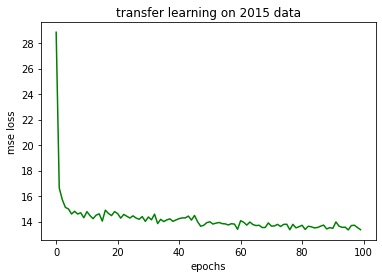

time taken: 5.088825702667236


In [ ]:
a = pred_and_retrain(model1,x_2015,y_2015,"transfer learning on 2015 data")
tl_losses.append(a[0])
tl_times.append(a[1])

loss: 4.79752751374028


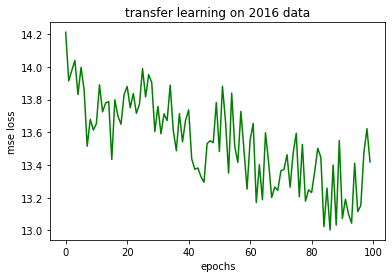

time taken: 5.054609775543213


In [ ]:
a=pred_and_retrain(model1,x_2016,y_2016,"transfer learning on 2016 data")
tl_losses.append(a[0])
tl_times.append(a[1])

loss: 5.002620179416628


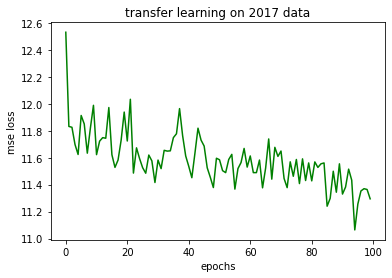

time taken: 5.037362337112427


In [ ]:
a=pred_and_retrain(model1,x_2017,y_2017,"transfer learning on 2017 data")
tl_losses.append(a[0])
tl_times.append(a[1])

loss: 4.015529691833918


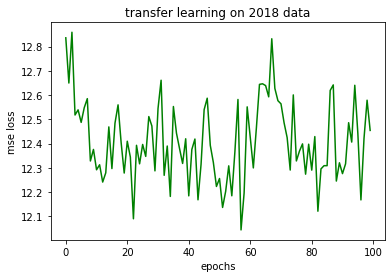

time taken: 5.107733249664307


In [ ]:
a=pred_and_retrain(model1,x_2018,y_2018,"transfer learning on 2018 data")
tl_losses.append(a[0])
tl_times.append(a[1])

loss: 4.1727631749076775


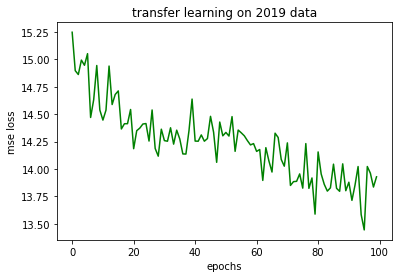

time taken: 5.03730034828186


In [ ]:
a=pred_and_retrain(model1,x_2019,y_2019,"transfer learning on 2019 data")
tl_losses.append(a[0])
tl_times.append(a[1])

In [ ]:
print("total time taken:",sum(tl_times),"seconds")
tl_data = {'years':[2015,2016,2017,2018,2019], 'losses':tl_losses, 'time taken':tl_times}
tl_df = pd.DataFrame(tl_data)
tl_df.head()

total time taken: 25.325831413269043 seconds


,years,losses,time taken
0,2015,9.693184,5.088826
1,2016,4.797528,5.054610
2,2017,5.002620,5.037362
3,2018,4.015530,5.107733
4,2019,4.172763,5.037300


In [ ]:
mean = sum(tl_losses[1:]) / len(tl_losses[1:]) 
sd = sum((i - mean) ** 2 for i in tl_losses[1:]) / len(tl_losses[1:]) 
print("mean loss=",mean,"\nstandard deviation of loss=",sd)

mean loss= 4.497110139974627 
standard deviation of loss= 0.17072792005411308


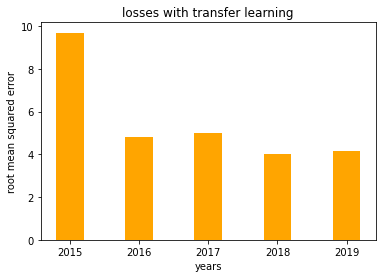

In [ ]:
plt.bar([2015,2016,2017,2018,2019], tl_losses, color ='orange', width = 0.4) 
plt.xlabel('years')
plt.ylabel('root mean squared error') 
plt.title('losses with transfer learning')   
plt.show()

#complete retraining


> retraining all layers


In [ ]:
cr_losses = []
cr_times = []

loss: 10.261113364243649


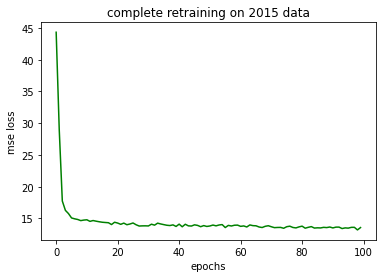

time taken: 5.125569105148315


In [ ]:
a = pred_and_retrain(model2,x_2015,y_2015,"complete retraining on 2015 data")
cr_losses.append(a[0])
cr_times.append(a[1])

loss: 4.441733797765128


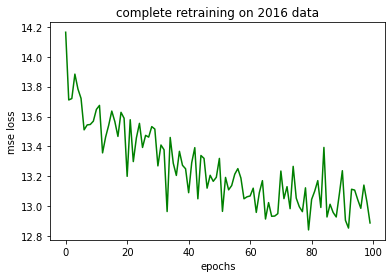

time taken: 5.06283164024353


In [ ]:
a = pred_and_retrain(model2,x_2016,y_2016,"complete retraining on 2016 data")
cr_losses.append(a[0])
cr_times.append(a[1])

loss: 5.648891480247865


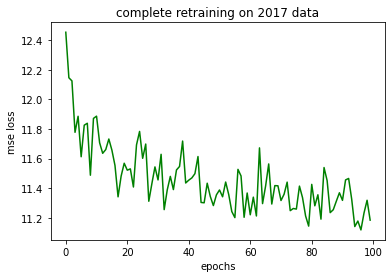

time taken: 5.090484380722046


In [ ]:
a = pred_and_retrain(model2,x_2017,y_2017,"complete retraining on 2017 data")
cr_losses.append(a[0])
cr_times.append(a[1])

loss: 4.254091398521028


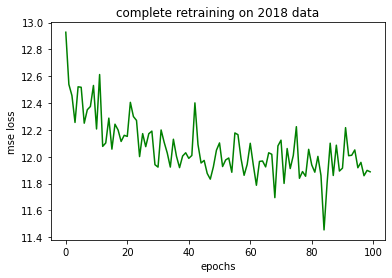

time taken: 5.117862939834595


In [ ]:
a = pred_and_retrain(model2,x_2018,y_2018,"complete retraining on 2018 data")
cr_losses.append(a[0])
cr_times.append(a[1])

loss: 4.770480921632106


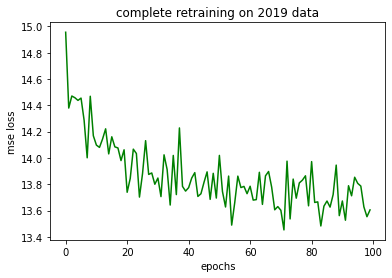

time taken: 5.226993799209595


In [ ]:
a = pred_and_retrain(model2,x_2019,y_2019,"complete retraining on 2019 data")
cr_losses.append(a[0])
cr_times.append(a[1])

In [ ]:
print("total time taken:",sum(cr_times),"seconds")
cr_data = {'years':[2015,2016,2017,2018,2019], 'losses':cr_losses, 'time taken':cr_times}
cr_df = pd.DataFrame(cr_data)
cr_df.head()

total time taken: 25.62374186515808 seconds


,years,losses,time taken
0,2015,10.261113,5.125569
1,2016,4.441734,5.062832
2,2017,5.648891,5.090484
3,2018,4.254091,5.117863
4,2019,4.770481,5.226994


In [ ]:
mean = sum(cr_losses[1:]) / len(cr_losses[1:]) 
sd = sum((i - mean) ** 2 for i in cr_losses[1:]) / len(cr_losses[1:]) 
print("mean loss=",mean,"\nstandard deviation of loss=",sd)

mean loss= 4.778799399541532 
standard deviation of loss= 0.28651528305460733


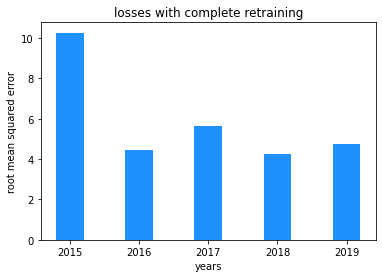

In [ ]:
plt.bar(cr_df['years'],cr_df['losses'], color ='dodgerblue', width = 0.4) 
plt.xlabel('years')
plt.ylabel('root mean squared error') 
plt.title('losses with complete retraining')    
plt.show()

# No retraining

---

We create a model similar to the other models but we do not retrain. This is done for comparison purposes.

In [ ]:
gen_loss = []
gen_time = []

In [ ]:
model3 = keras.Sequential([
    keras.Input(shape=(14)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1),
])

optimizer = tf.keras.optimizers.RMSprop(0.01)

model3.compile(loss='mse', optimizer=optimizer, metrics=['mse'],)
model3.fit(x,y,epochs=100, verbose=0)

In [ ]:
def pred_and_retrain_m3(x,y):
  time1=time.time()
  a=model3.predict(x)
  b=sqrt(mean_squared_error(y,a))
  time2=time.time()
  return (b,time2-time1)

No handles with labels found to put in legend.


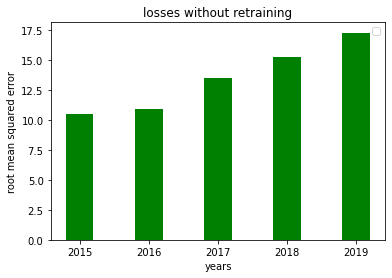

In [ ]:
a = pred_and_retrain_m3(x_2015,y_2015)
gen_loss.append(a[0])
gen_time.append(a[1])
a = pred_and_retrain_m3(x_2016,y_2016)
gen_loss.append(a[0])
gen_time.append(a[1])
a = pred_and_retrain_m3(x_2017,y_2017)
gen_loss.append(a[0])
gen_time.append(a[1])
a = pred_and_retrain_m3(x_2018,y_2018)
gen_loss.append(a[0])
gen_time.append(a[1])
a = pred_and_retrain_m3(x_2019,y_2019)
gen_loss.append(a[0])
gen_time.append(a[1])

plt.bar([2015,2016,2017,2018,2019], gen_loss, color ='green', width = 0.4) 
plt.xlabel('years')
plt.ylabel('root mean squared error') 
plt.title('losses without retraining')   
plt.legend() 
plt.show()

# Comparisons

---



> complete retraining and transfer learning



Text(0, 0.5, 'root mean square error')

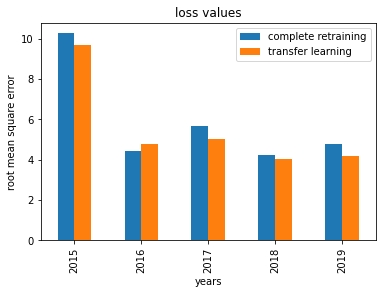

In [ ]:
df=pd.DataFrame({'years':tl_df['years'].values,'complete retraining':cr_df['losses'].values,'transfer learning':tl_df['losses'].values})
ax=df.plot(x='years', y=['complete retraining','transfer learning'], kind="bar",title="loss values")
ax.set_ylabel("root mean square error")

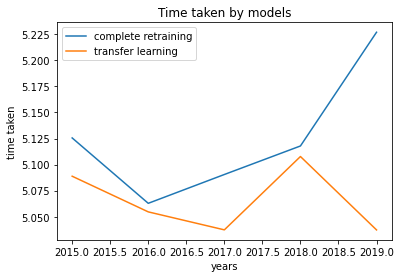

In [ ]:
plt.plot(cr_df['years'], cr_df['time taken'], label = "complete retraining") 
plt.plot(tl_df['years'], tl_df['time taken'], label = "transfer learning") 
  
plt.xlabel('years')
plt.ylabel('time taken') 
plt.title('Time taken by models') 
   
plt.legend() 
plt.show() 



> all 3



Text(0, 0.5, 'root mean square error')

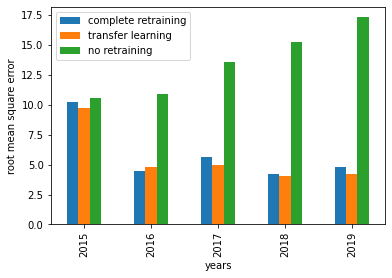

In [ ]:
df=pd.DataFrame({'years':tl_df['years'].values,'complete retraining':cr_df['losses'].values,'transfer learning':tl_df['losses'].values,'no retraining':gen_loss})
ax=df.plot(x='years', y=['complete retraining','transfer learning','no retraining'], kind="bar")
ax.set_ylabel("root mean square error")

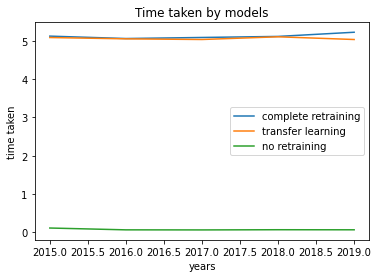

In [ ]:
plt.plot(cr_df['years'], cr_df['time taken'], label = "complete retraining") 
plt.plot(tl_df['years'], tl_df['time taken'], label = "transfer learning") 
plt.plot(tl_df['years'], gen_time, label = "no retraining") 

plt.xlabel('years')
plt.ylabel('time taken') 
plt.title('Time taken by models') 
   
plt.legend() 
plt.show() 